In [63]:
import numpy as np
import cv2

import os
from os import path as osp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from model.net import DGCNet

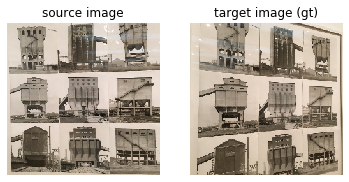

In [64]:
IMG_PATH = 'imgs'
IMG_SIZE_DGC = (240, 240)

img1 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '1.ppm'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)
img2 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '2.ppm'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img1);
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');


In [69]:
class DeNormalize:
    '''
    Removes normalization using the mean, std specified
    '''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


# Image pre-processing constants
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Image de-normalization
restore_image = DeNormalize(mean, std)

# Prepare data for the network
dataset_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [77]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

net = DGCNet()
net.load_state_dict(torch.load(osp.join('pretrained_models',
                                        'dgc',
                                        'checkpoint.pth'),
                               map_location=torch.device(device))['state_dict'])
net.eval()
net.to(device);

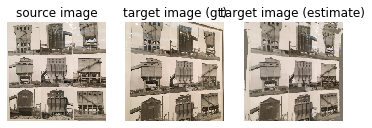

In [73]:
with torch.no_grad():
    # predict the warping grid between two images
    estimates_grid_pyr, _ = net(dataset_transforms(img1).unsqueeze(0), dataset_transforms(img2).unsqueeze(0))
    # warp the source image based on the estimates to be aligned with the target view
    warp_img = F.grid_sample(dataset_transforms(img1).unsqueeze(0), estimates_grid_pyr[-1].permute(0, 2, 3, 1))


# Visualize the results
plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(img1);
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(restore_image(warp_img.squeeze()).permute(1, 2, 0).cpu().numpy());
ax3.axis('off')
ax3.set_title('target image (estimate)');
